## Test Marlena

Idee:
* visualizzazione dell'albero decisionale con il path "illuminato" della regola
* inserire il tutto in una pagina web

In [1]:
from marlena.marlena import MARLENA
from marlena.preprocessing import prepare_dataset

In [2]:
import pandas as pd

We can use the `prepare_dataset` function to automatically detect and prepare our dataset:

In [3]:
file_path = './marlena/nys-patient-characteristics-survey-pcs-2015/patient-characteristics-survey-pcs-2015.csv'
labels = ['Diabetes','Obesity','Heart Attack','Stroke','Other Cardiac']

df, numerical_vars, labels_name, categorical_vars = prepare_dataset(file_path,labels=labels)

reading dataset patient-characteristics-survey-pcs-2015.csv
labels names: 
['Diabetes' 'Obesity' 'Heart Attack' 'Stroke' 'Other Cardiac']
dropping 0 columns:
[]
leaving 5 columns:
['Diabetes' 'Obesity' 'Heart Attack' 'Stroke' 'Other Cardiac']

drop all columns containing null values (we prefer to keep instances rather than features)
dropping 0 columns:
[]
leaving 62 columns:
['Survey Year' 'Program Category' 'Region Served' 'Age Group' 'Sex'
 'Transgender' 'Sexual Orientation' 'Hispanic Ethnicity' 'Race'
 'Living Situation' 'Household Composition' 'Preferred Language'
 'Veteran Status' 'Employment Status' 'Number Of Hours Worked Each Week'
 'Education Status' 'Special Education Services' 'Mental Illness'
 'Intellectual Disability' 'Autism Spectrum'
 'Other Developmental Disability' 'Alcohol Related Disorder'
 'Drug Substance Disorder' 'Mobility Impairment Disorder'
 'Hearing Visual Impairment' 'Hyperlipidemia' 'High Blood Pressure'
 'Pulmonary Asthma' 'Alzheimer or Dementia' 'Kidney Di

The preprocessing function tries to automatically remove `Nan`(missing) values and it "dummifies" the categorical ones, but since it is an authomatic process, it might be wrong, for example in this dataset there is no Nan but other kind of missin values:

In [4]:
labels_name

['Diabetes=NO',
 'Diabetes=UNKNOWN',
 'Diabetes=YES',
 'Obesity=NO',
 'Obesity=UNKNOWN',
 'Obesity=YES',
 'Heart Attack=NO',
 'Heart Attack=UNKNOWN',
 'Heart Attack=YES',
 'Stroke=NO',
 'Stroke=UNKNOWN',
 'Stroke=YES',
 'Other Cardiac=NO',
 'Other Cardiac=UNKNOWN',
 'Other Cardiac=YES']

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
check_df = pd.read_csv(file_path)
print(f'shape: {check_df.shape}')
n_cols_unknown = len([col for col in check_df.columns if "UNKNOWN" in check_df[col].values])

print(f'{n_cols_unknown} out of {len(check_df.columns)} columns contain the UNKNOWN value:\n')

for col in check_df.columns:
    col_vals = check_df[col].values
    if 'UNKNOWN' in col_vals:
        perc_unknown = len(col_vals[col_vals=='UNKNOWN'])/len(col_vals)
        print(f'the percentage of unknown values in {col} is {perc_unknown}')
        if perc_unknown>0.1:
            #rimuovi la colonna
            check_df.drop(col,1,inplace=True)
        else:
            #rimuovi le righe
            indexes_unknown = check_df[check_df[col]=="UNKNOWN"].index.values
            check_df.drop(indexes_unknown,inplace=True)


shape: (179096, 67)
58 out of 67 columns contain the UNKNOWN value:

the percentage of unknown values in Age Group is 0.00010050475722517533

the percentage of unknown values in Sex is 0.00209964373066485

the percentage of unknown values in Transgender is 0.02722409374265537

the percentage of unknown values in Sexual Orientation is 0.07731955797672532

the percentage of unknown values in Hispanic Ethnicity is 0.014563954213322027

the percentage of unknown values in Living Situation is 0.00764266734151588

the percentage of unknown values in Household Composition is 0.018565271721112896

the percentage of unknown values in Preferred Language is 0.0023970378069377678

the percentage of unknown values in Veteran Status is 0.015582369067076466

the percentage of unknown values in Education Status is 0.053268332693910486

the percentage of unknown values in Special Education Services is 0.006029694323144105

the percentage of unknown values in Mental Illness is 0.006319326313421715

the 

In [7]:
#quante colonne e righe sono sopravvissute a questa operazione?
check_df.shape

(105216, 66)

In [8]:
dummified_check_df = pd.get_dummies(check_df.drop('Survey Year',1),prefix_sep='=')
dummified_check_df = pd.concat([dummified_check_df,check_df['Survey Year']],1)

In [9]:
check_df.groupby('Transgender').size()

Transgender
CLIENT DIDN'T ANSWER       472
NO, NOT TRANSGENDER     103988
YES, TRANSGENDER           756
dtype: int64

In [10]:
numerical_vars= ['Survey Year']
labels_name = [col for col in dummified_check_df.columns if ('Diabetes' in col) or ('Obesity' in col) or ('Heart Attack' in col)]
categorical_vars = [col for col in dummified_check_df if col not in labels_name and col not in numerical_vars]

In [11]:
from sklearn.ensemble import RandomForestClassifier

dummified_check_df = dummified_check_df.reset_index(drop=True)

bb = RandomForestClassifier()
bb.fit(dummified_check_df[numerical_vars+categorical_vars].values,dummified_check_df[labels_name].values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [12]:
m1 = MARLENA(neigh_type='unified')

In [13]:
i2e = dummified_check_df.loc[2, numerical_vars+categorical_vars]

rule, instance_imporant_feat, fidelity, hit, DT = m1.extract_explanation(i2e, dummified_check_df, bb, numerical_vars, categorical_vars, labels_name, k=200, size=2000,alpha=0.1)

MARLENA-unified
decision rule: {Medicaid Insurance=YES = False, Joint Disease=NO = True, Autism Spectrum=YES = False, Stroke=NO = True, Private Insurance=YES = False, Medicaid and Medicare Insurance=YES = False, Endocrine Condition=NO = True, Traumatic Brain Injury=YES = False} -> ['Diabetes=NO' 'Obesity=NO' 'Heart Attack=NO']
rule length: 8
black-box decision: [[1. 0. 1. 0. 1. 0.]]
explained decision: [[1. 0. 1. 0. 1. 0.]]
fidelity of DT: 0.9709566164458159
hit: 1.0


In [14]:
DT

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=90, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

https://datascience.stackexchange.com/questions/28574/decisiontreeclassifier-object-has-no-attribute-importances

In [15]:
feat_names = dummified_check_df[numerical_vars+categorical_vars].columns.values
class_names = dummified_check_df[labels_name].columns.values

In [16]:
#esporto il DT in formato dot
from sklearn import tree
import graphviz
tree.export_graphviz(DT, out_file="./mytree_prova.dot",\
                     feature_names=feat_names,\
                     class_names=class_names,\
                     label='root',\
                     impurity=False,\
                     proportion=True,\
                     precision=2) 

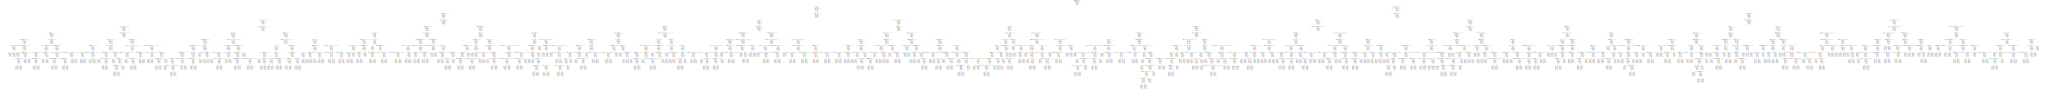

In [17]:
with open("./mytree_prova.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)